# Implementing SIR with three strains in circulation
This conceptual model shows how an SIR model with three circulating strains could be implemented

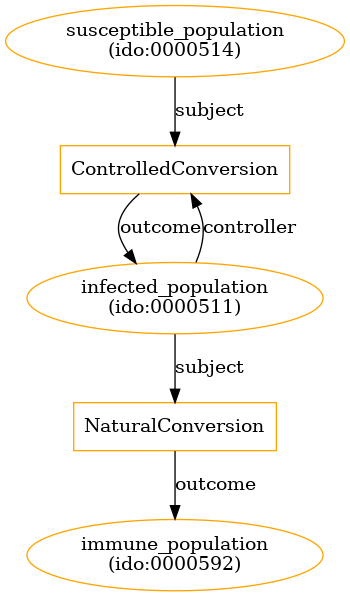

In [1]:
# Get an ready-made example SIR model that has parameters and initial values already set
# (note that the model is missing units)
from mira.examples.sir import sir_parameterized_init, sir_init_val_norm
from mira.metamodel import *

susceptible = sir_parameterized_init.get_concepts_name_map()['susceptible_population']
infected = sir_parameterized_init.get_concepts_name_map()['infected_population']
recovered = sir_parameterized_init.get_concepts_name_map()['immune_population']

sir_parameterized_init.draw_jupyter()

In [2]:
sir_parameterized_init.initials

{'susceptible_population': Initial(concept=Concept(name='susceptible_population', display_name=None, description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)), expression=99999.0),
 'infected_population': Initial(concept=Concept(name='infected_population', display_name=None, description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), expression=1),
 'immune_population': Initial(concept=Concept(name='immune_population', display_name=None, description=None, identifiers={'ido': '0000592'}, context={}, units=Unit(expression=person)), expression=0)}

## Stratify the model and allow re-infection from different strains
With three different strains in circulation, it is resonable to assume that there can be reinfection happening. We start by an initial stratification into three infection processes, one for each strain. Here we keep the initials susceptible state unstratified.

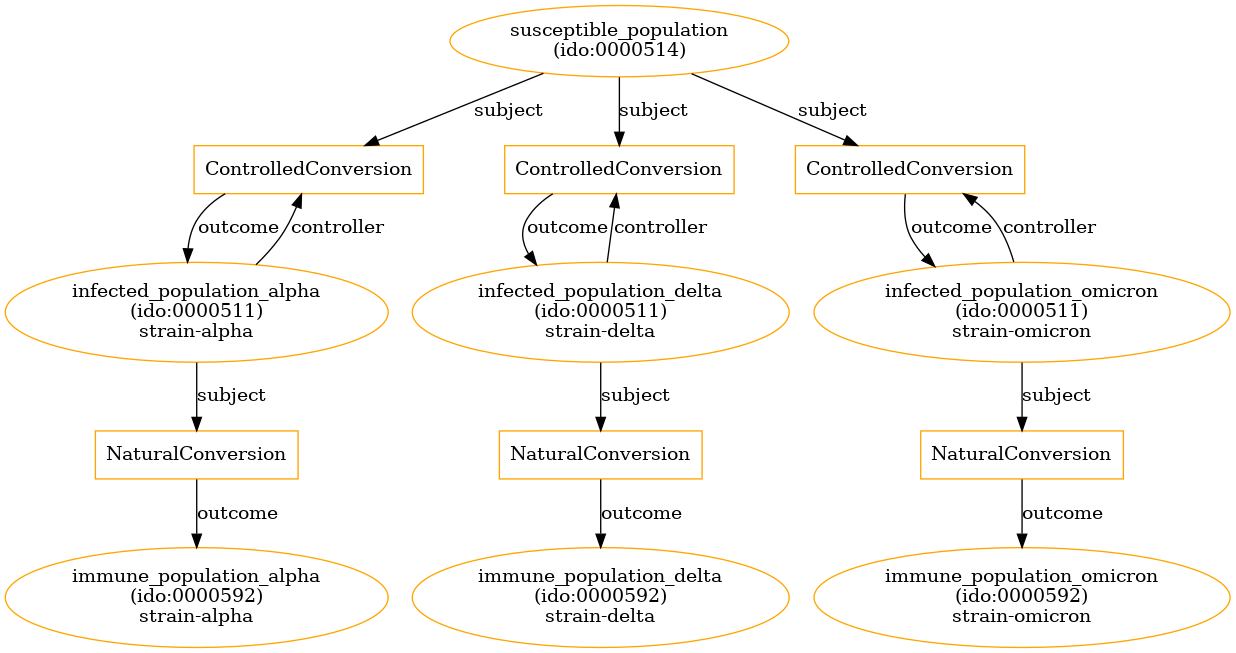

In [3]:
from mira.metamodel.ops import stratify
strains = ['alpha', 'delta', 'omicron']

# Passing an empty list to structure creates three separate paths for each strain
strain_model = stratify(
    sir_parameterized_init, 
    key='strain', 
    strata=strains, 
    concepts_to_preserve=['susceptible_population'], 
    structure=[],
)
strain_model.draw_jupyter("sir.png")

In [4]:
for name, init in strain_model.initials.items():
    print(name, init.expression)

susceptible_population 99999.0
infected_population_alpha 1/3
infected_population_delta 1/3
infected_population_omicron 1/3
immune_population_alpha 0
immune_population_delta 0
immune_population_omicron 0


## Add re-infection to other strains
Now we need to add reinfection to other strains, i.e. recovered/immune from alpha can be reinfected with delta or omicron strains and so forth, and after the first reinfection a second reinfection is possible from the remaining strain. During infection, order of previous infection matters, i.e. I_alpha_delta is not the same as I_delta_alpha (the former had an initial infection of alpha, recovered and is now infected with delta, and vice-versa for the latter).

In [5]:
initials = {}

# Reset the infected populations to 1 (they're set to 1/3 when stratified)
initials['susceptible_population'] = Initial(concept=Concept(name='susceptible_population'), expression=sir_init_val_norm - 3.0)

name_map = strain_model.get_concepts_name_map()

infected_alpha = strain_model.get_concepts_name_map()['infected_population_alpha']
initials[infected_alpha.name] = Initial(concept=Concept(name=infected_alpha.name), expression=1.0)

infected_delta = strain_model.get_concepts_name_map()['infected_population_delta']
initials[infected_delta.name] = Initial(concept=Concept(name=infected_delta.name), expression=1.0)

infected_omicron = strain_model.get_concepts_name_map()['infected_population_omicron']
initials[infected_omicron.name] = Initial(concept=Concept(name=infected_omicron.name), expression=1.0)

recovered_alpha = strain_model.get_concepts_name_map()['immune_population_alpha']
recovered_delta = strain_model.get_concepts_name_map()['immune_population_delta']
recovered_omicron = strain_model.get_concepts_name_map()['immune_population_omicron']

# Get reinfected states and reinfected recovered states, set all initials to zero
# alpha delta/delta alpha
infected_alpha_delta = infected.with_context(history='alpha', strain='delta')
infected_alpha_delta.name = 'infected_population_alpha_delta'
initials[infected_alpha_delta.name] = Initial(concept=Concept(name=infected_alpha_delta.name), expression=0.0)

infected_delta_alpha = infected.with_context(history='delta', strain='alpha')
infected_delta_alpha.name = 'infected_population_delta_alpha'
initials[infected_delta_alpha.name] = Initial(concept=Concept(name=infected_delta_alpha.name), expression=0.0)

recovered_alpha_delta = recovered.with_context(history='alpha_delta')
recovered_alpha_delta.name = 'immune_population_alpha_delta'
initials[recovered_alpha_delta.name] = Initial(concept=Concept(name=recovered_alpha_delta.name), expression=0.0)

# alpha omicron/omicron alpha
infected_alpha_omicron = infected.with_context(history='alpha', strain='omicron')
infected_alpha_omicron.name = 'infected_population_alpha_omicron'
initials[infected_alpha_omicron.name] = Initial(concept=Concept(name=infected_alpha_omicron.name), expression=0.0)

infected_omicron_alpha = infected.with_context(history='omicron', strain='alpha')
infected_omicron_alpha.name = 'infected_population_omicron_alpha'
initials[infected_omicron_alpha.name] = Initial(concept=Concept(name=infected_omicron_alpha.name), expression=0.0)

recovered_alpha_omicron = recovered.with_context(history='alpha_omicron')
recovered_alpha_omicron.name = 'immune_population_alpha_omicron'
initials[recovered_alpha_omicron.name] = Initial(concept=Concept(name=recovered_alpha_omicron.name), expression=0.0)

# delta omicron/omicron delta
infected_delta_omicron = infected.with_context(history='delta', strain='omicron')
infected_delta_omicron.name = 'infected_population_delta_omicron'
initials[infected_delta_omicron.name] = Initial(concept=Concept(name=infected_delta_omicron.name), expression=0.0)

infected_omicron_delta = infected.with_context(history='omicron', strain='delta')
infected_omicron_delta.name = 'infected_population_omicron_delta'
initials[infected_omicron_delta.name] = Initial(concept=Concept(name=infected_omicron_delta.name), expression=0.0)

recovered_delta_omicron = recovered.with_context(strain='delta_omicron')
recovered_delta_omicron.name = 'immune_population_delta_omicron'
initials[recovered_delta_omicron.name] = Initial(concept=Concept(name=recovered_delta_omicron.name), expression=0.0)

# alpha delta omicron (third and final infection for any branch)
infected_alpha_delta_omicron = infected.with_context(history='alpha_delta', strain='omicron')
infected_alpha_delta_omicron.name = 'infected_population_alpha_delta_omicron'
initials[infected_alpha_delta_omicron.name] = Initial(concept=Concept(name=infected_alpha_delta_omicron.name), expression=0.0)

infected_alpha_omicron_delta = infected.with_context(history='alpha_omicron', strain='delta')
infected_alpha_omicron_delta.name = 'infected_population_alpha_omicron_delta'
initials[infected_alpha_omicron_delta.name] = Initial(concept=Concept(name=infected_alpha_omicron_delta.name), expression=0.0)

infected_delta_omicron_alpha = infected.with_context(history='delta_omicron', strain='alpha')
infected_delta_omicron_alpha.name = 'infected_population_delta_omicron_alpha'
initials[infected_delta_omicron_alpha.name] = Initial(concept=Concept(name=infected_delta_omicron_alpha.name), expression=0.0)

recovered_alpha_delta_omicron = recovered.with_context(history='alpha_delta_omicron')
recovered_alpha_delta_omicron.name = 'immune_population_alpha_delta_omicron'
initials[recovered_alpha_delta_omicron.name] = Initial(concept=Concept(name=recovered_alpha_delta_omicron.name), expression=0.0)

In [6]:
# Create infections from other strains and set their rates
new_templates = []
new_parameters = {}

# alpha/omicron -> delta infection (i.e. gain a delta infection from any compartment currently infected with delta)
for rec_name, subject, outcome, recovery in [
        ('alpha', recovered_alpha, infected_alpha_delta, recovered_alpha_delta),
        ('omicron', recovered_omicron, infected_omicron_delta, recovered_delta_omicron),
        ('alpha_omicron', recovered_alpha_omicron, infected_alpha_omicron_delta, recovered_alpha_delta_omicron),
]:
    for name, infector in [
            ('delta', infected_delta),
            ('alpha_delta', infected_alpha_delta),
            ('omicron_delta', infected_omicron_delta),
            ('alpha_omicron_delta', infected_alpha_omicron_delta),  # omicron_alpha_delta == alpha_omicron_delta
    ]:
        cc = ControlledConversion(
            subject=subject,
            controller=infector,
            outcome=outcome
        )
        param_name = f"beta_{rec_name}_{name}"
        cc.set_mass_action_rate_law(param_name)
        new_parameters[param_name] = Parameter(name=param_name, value=1)
        new_templates.append(cc)

        nc = NaturalConversion(
            subject=outcome,
            outcome=recovery
        )
        param_name_rec = f"gamma_{name}"
        nc.set_mass_action_rate_law(param_name_rec)
        new_parameters[param_name] = Parameter(name=param_name_rec, value=1)
        new_templates.append(nc)


# delta/omicron -> alpha infection (i.e. gain alpha infection)
for rec_name, subject, outcome, recovery in [
        ('delta', recovered_delta, infected_delta_alpha, recovered_alpha_delta),
        ('omicron', recovered_omicron, infected_omicron_alpha, recovered_alpha_omicron),
        ('delta_omicron', recovered_delta_omicron, infected_delta_omicron_alpha, recovered_alpha_delta_omicron),
]:
    for name, infector in [
            ('alpha', infected_alpha),
            ('delta_alpha', infected_delta_alpha),
            ('omicron_alpha', infected_omicron_alpha),
            ('delta_omicron_alpha', infected_delta_omicron_alpha)
    ]:
        cc = ControlledConversion(
            subject=subject,
            controller=infector,
            outcome=outcome
        )
        param_name = f"beta_{rec_name}_{name}"
        cc.set_mass_action_rate_law(param_name)
        new_parameters[param_name] = Parameter(name=param_name, value=1)
        new_templates.append(cc)
        
        if recovery is not None:
            nc = NaturalConversion(
                subject=outcome,
                outcome=recovery
            )
            param_name_rec = f"gamma_{name}"
            nc.set_mass_action_rate_law(param_name_rec)
            new_parameters[param_name_rec] = Parameter(name=param_name_rec, value=1)
            new_templates.append(nc)


# alpha/delta -> omicron infection (i.e. gain omicron infection)
for rec_name, subject, outcome, recovery in [
        ('alpha', recovered_alpha, infected_alpha_omicron, recovered_alpha_omicron),
        ('delta', recovered_delta, infected_delta_omicron, recovered_delta_omicron),
        ('alpha_delta', recovered_alpha_delta, infected_alpha_delta_omicron, recovered_alpha_delta_omicron),
]:
    for name, infector in [
            ('omicron', infected_omicron),
            ('alpha_omicron', infected_alpha_omicron),
            ('delta_omicron', infected_delta_omicron),
            ('alpha_delta_omicron', infected_alpha_delta_omicron)
    ]:
        cc = ControlledConversion(
            subject=subject,
            controller=infector,
            outcome=outcome
        )
        param_name = f"beta_{rec_name}_{name}"
        cc.set_mass_action_rate_law(param_name)
        new_parameters[param_name] = Parameter(name=param_name, value=1)
        new_templates.append(cc)

        if recovery is not None:
            nc = NaturalConversion(
                subject=outcome,
                outcome=recovery,
            )
            param_name_rec = f"gamma_{name}"
            nc.set_mass_action_rate_law(param_name_rec)
            new_parameters[param_name_rec] = Parameter(name=param_name, value=1)
            new_templates.append(nc)

extenstion_tm = TemplateModel(templates=new_templates, parameters=new_parameters, initials=initials)

total_tm = strain_model.extend(extenstion_tm, parameter_mapping=new_parameters, initial_mapping=initials)

In [7]:
for name in total_tm.get_concepts_name_map():
    assert name in total_tm.initials
    print(name, total_tm.initials[name].expression)

susceptible_population 99997.0
infected_population_alpha 1.0
infected_population_delta 1.0
infected_population_omicron 1.0
immune_population_alpha 0
immune_population_delta 0
immune_population_omicron 0
infected_population_alpha_delta 0.0
immune_population_alpha_delta 0.0
infected_population_omicron_delta 0.0
infected_population_alpha_omicron_delta 0.0
immune_population_delta_omicron 0.0
immune_population_alpha_omicron 0.0
immune_population_alpha_delta_omicron 0.0
infected_population_delta_alpha 0.0
infected_population_omicron_alpha 0.0
infected_population_delta_omicron_alpha 0.0
infected_population_alpha_omicron 0.0
infected_population_delta_omicron 0.0
infected_population_alpha_delta_omicron 0.0


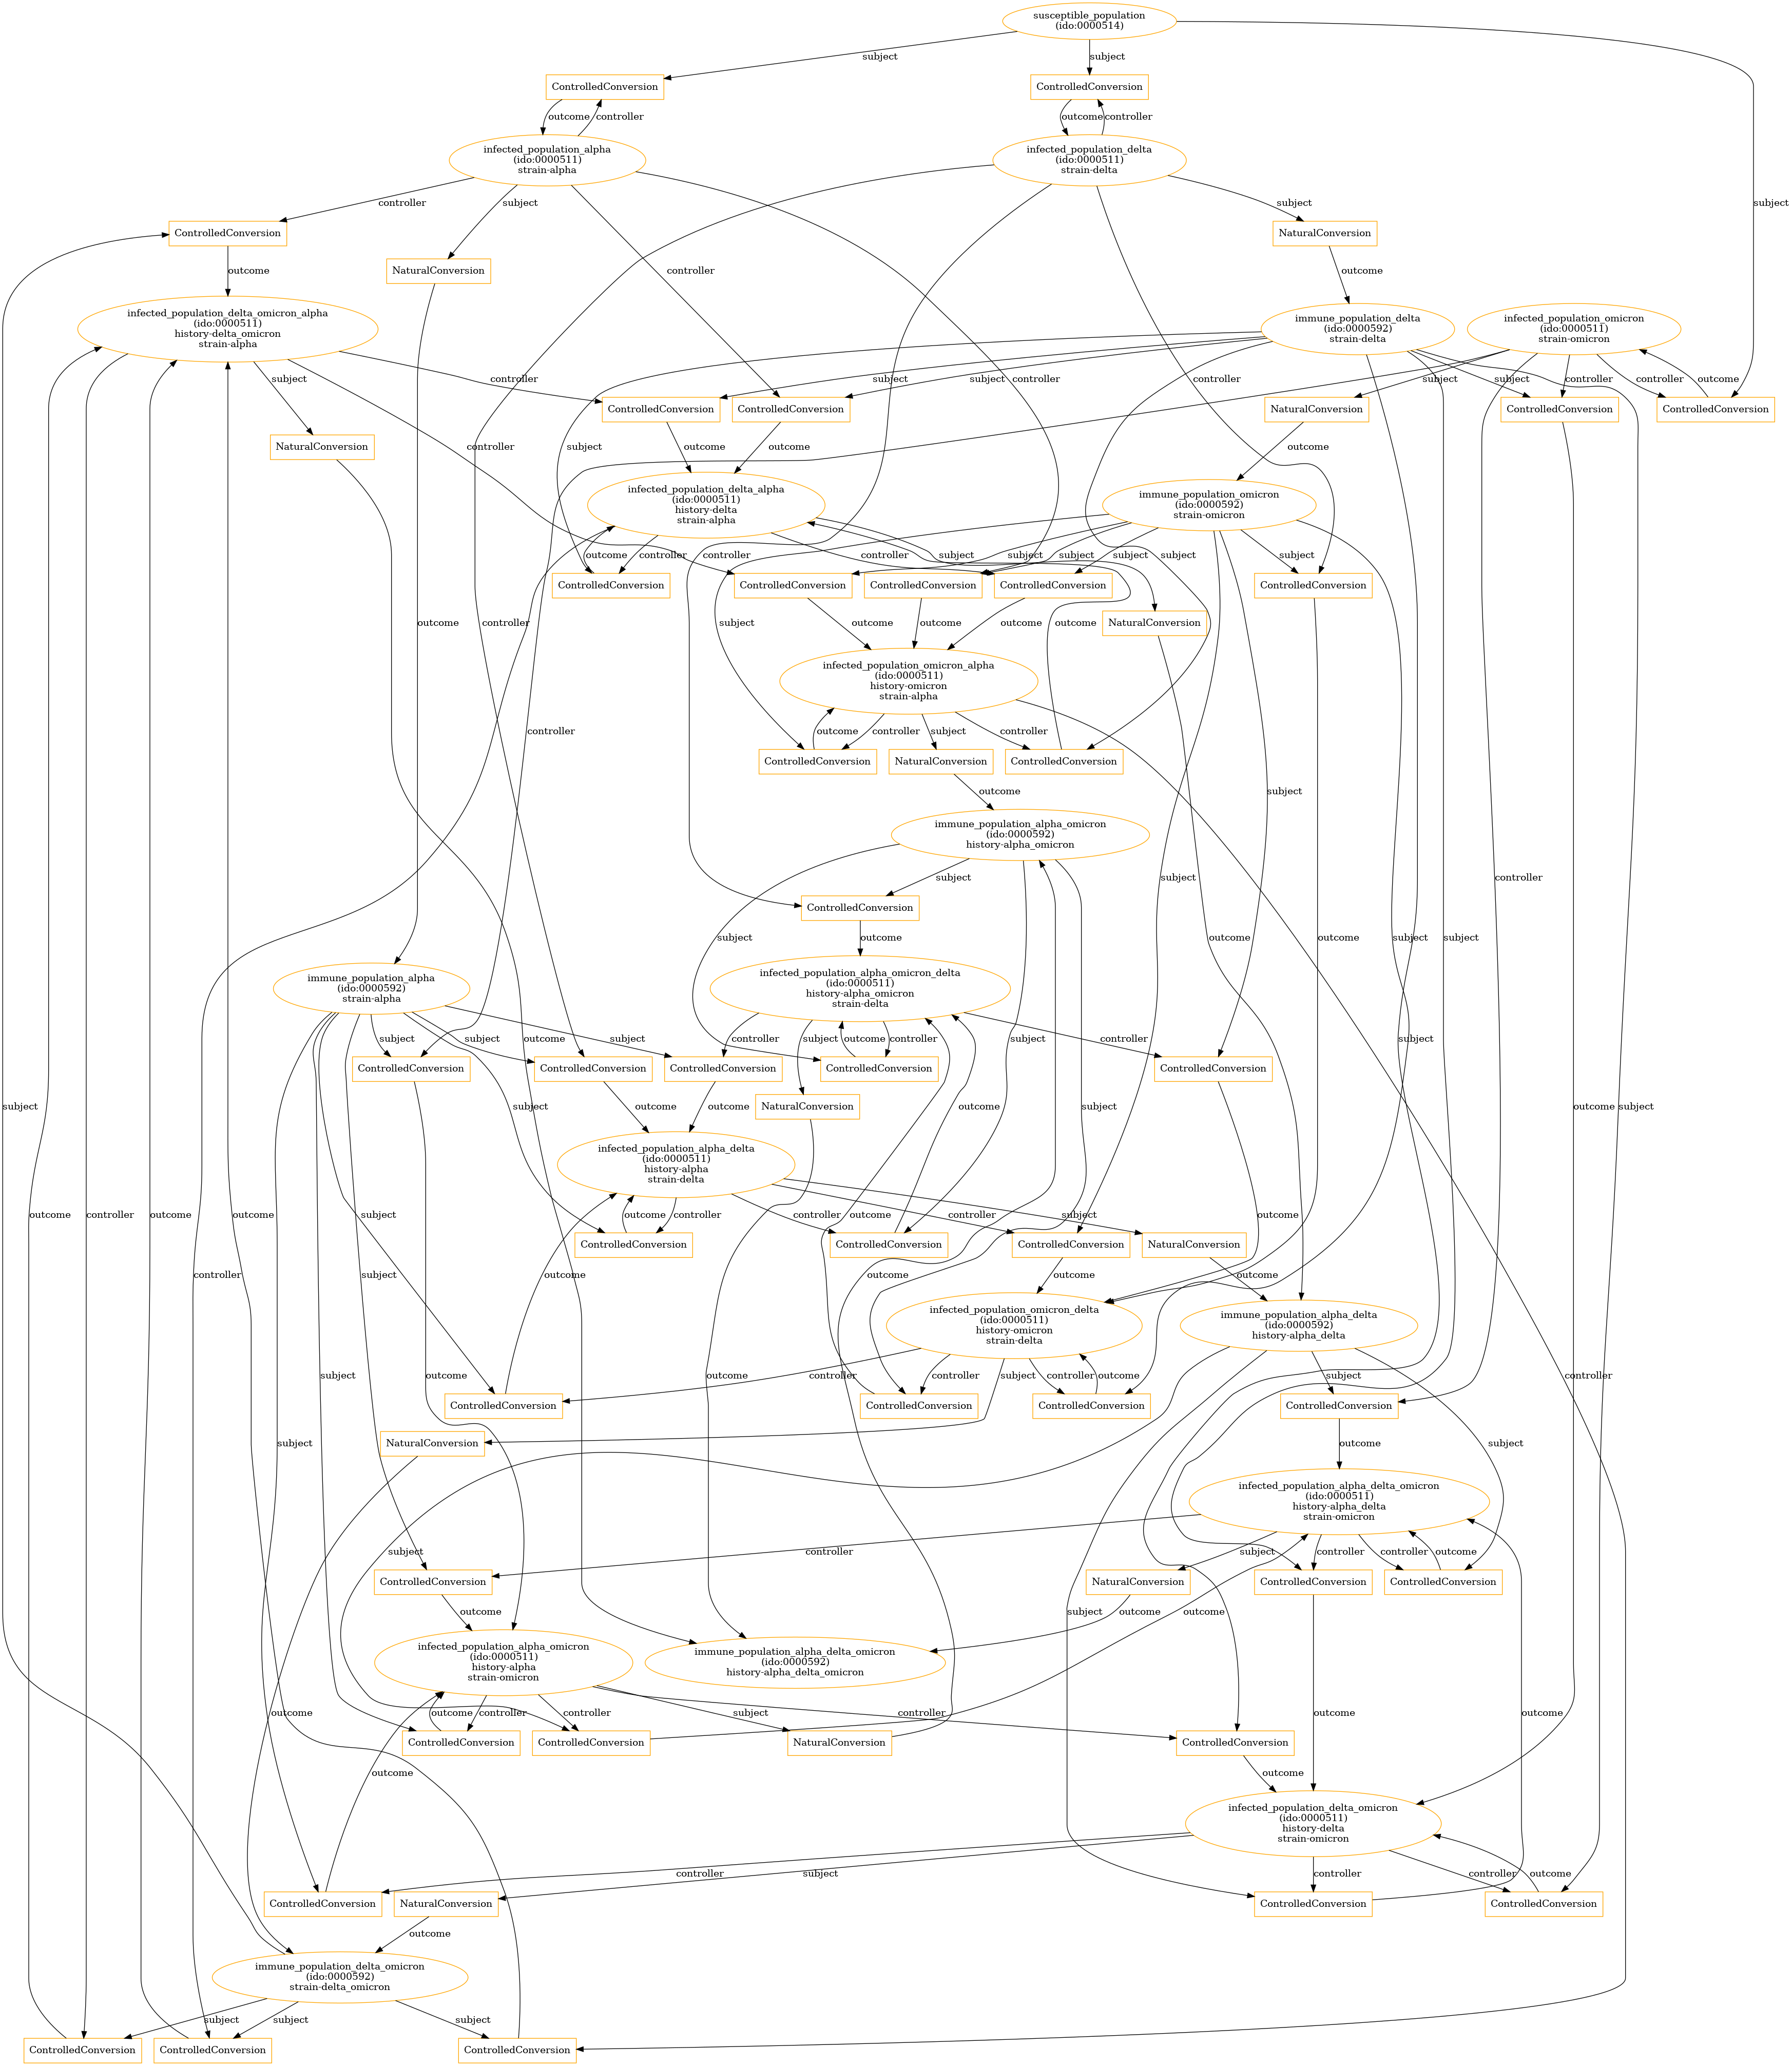

In [8]:
import json
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
for out_type, out_fun in [
        ('regnet', template_model_to_regnet_json),
        ('petrinet', template_model_to_petrinet_json)
]:
    with open(f"sir_3strain_{out_type}.json", 'w') as f:
        json.dump(out_fun(total_tm), f, indent=1)
total_tm.draw_jupyter("sir_3strain.png")